<a href="https://colab.research.google.com/github/benjmcarthur/kaggle-otto/blob/master/meta-MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# A MLP to combine all models as a meta learner

In [0]:
from sklearn.externals import joblib
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets,transforms
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import StratifiedKFold
import time as time
import matplotlib.pyplot as plt 
import os
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Import base learner results

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
models_dir = '/content/gdrive/My Drive/base_models'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
BigMLP_01scaled_train = joblib.load(models_dir + '/train-bigNN-01scaled')
BigMLP_01scaled_test = joblib.load(models_dir + '/test-bigNN-01scaled')

BigMLP_logXplus1_train = joblib.load(models_dir + '/train-bigNN-log(x+1)')
BigMLP_logXplus1_test = joblib.load(models_dir + '/test-bigNN-log(x+1)')

BigMLP_notscaled_train = joblib.load(models_dir + '/train-bigNN-notscaled')
BigMLP_notscaled_test = joblib.load(models_dir + '/test-bigNN-notscaled')

BigMLP_stdscaled_train = joblib.load(models_dir + '/train-bigNN-standardscaled')
BigMLP_stdscaled_test = joblib.load(models_dir + '/test-bigNN-standardscaled')

catboost_train = joblib.load(models_dir + '/train-catboost')
catboost_test = joblib.load(models_dir + '/test-catboost')

extraTrees_train = joblib.load(models_dir + '/train-extra_trees')
extraTrees_test = joblib.load(models_dir + '/test-extra_trees')

KNN16_train = joblib.load(models_dir + '/train-knn_16_0')
KNN16_test = joblib.load(models_dir + '/test-knn_16_0')

KNN32_train = joblib.load(models_dir + '/train-knn_32_0')
KNN32_test = joblib.load(models_dir + '/test-knn_32_0')

KNN64_train = joblib.load(models_dir + '/train-knn_64_0')
KNN64_test = joblib.load(models_dir + '/test-knn_64_0')

KNN128_train = joblib.load(models_dir + '/train-knn_128_0')
KNN128_test = joblib.load(models_dir + '/test-knn_128_0')

KNN256_train = joblib.load(models_dir + '/train-knn_256_0')
KNN256_test = joblib.load(models_dir + '/test-knn_256_0')

LGMB_dart_train = joblib.load(models_dir + '/train-lgmb_dart')
LGMB_dart_test = joblib.load(models_dir + '/test-lgmb_dart')

LGMB_gbdt_train = joblib.load(models_dir + '/train-lgmb_gbdt')
LGMB_gbdt_test = joblib.load(models_dir + '/test-lgmb_gbdt')

smallMLP_scaled_train = joblib.load(models_dir + '/train-mlp_small_0')
smallMLP_scaled_test = joblib.load(models_dir + '/test-mlp_small_0')

NaiveBayes_train = joblib.load(models_dir + '/train-Neive Bayes')
NaiveBayes_test = joblib.load(models_dir + '/test-Neive Bayes')

NaiveBayes_scaled_train = joblib.load(models_dir + '/train-Neive Bayes_0')
NaiveBayes_scaled_test = joblib.load(models_dir + '/test-Neive Bayes_0')

randomForest_train = joblib.load(models_dir + '/train-random_forest')
randomForest_test = joblib.load(models_dir + '/test-random_forest')

softmax_train = joblib.load(models_dir + '/train-Softmax')
softmax_test = joblib.load(models_dir + '/test-Softmax')

xgboost_train = joblib.load(models_dir + '/train-xgboost')
xgboost_test = joblib.load(models_dir + '/test-xgboost')

tsne3_train = joblib.load(models_dir + '/train-TSNE3')
tsne3_test = joblib.load(models_dir + '/test-TSNE3')

umap9_train = joblib.load(models_dir + '/train-UMAP9')
umap9_test = joblib.load(models_dir + '/test-UMAP9')

logreg_train = joblib.load(models_dir + '/train-LogReg')
logreg_test = joblib.load(models_dir + '/test-LogReg')

logreg_logscaled_train = joblib.load(models_dir + '/train-LogReg-log(X+1)')
logreg_logscaled_test = joblib.load(models_dir + '/test-LogReg-log(X+1)')

In [0]:
train_temp = pd.read_csv('./gdrive/My Drive/Colab Notebooks/Kaggle/Otto/train.csv')
labels = train_temp['target']
labels =  labels.map({'Class_1': 1, 'Class_2': 2,
                                  'Class_3': 3, 'Class_4': 4,
                                  'Class_5': 5, 'Class_6': 6,
                                  'Class_7': 7, 'Class_8': 8,
                                  'Class_9': 9})
labels = labels.astype('float64')
train_temp.drop(['target', 'id'], axis=1, inplace=True)
rawTrain = train_temp

In [0]:
test_temp = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Kaggle/Otto/test.csv")
ids = test_temp['id']
test_temp.drop(['id'], axis=1, inplace=True)
rawTest = test_temp

In [0]:
# Split the training set into k folds
# Try different numbers for k
n_splits = 20
kf = StratifiedKFold(n_splits=n_splits)

In [0]:
s_train = np.concatenate((
    BigMLP_01scaled_train,
    BigMLP_logXplus1_train,
    BigMLP_notscaled_train,
    BigMLP_stdscaled_train,
    catboost_train,
    extraTrees_train,
    KNN16_train,
    KNN32_train,
    KNN64_train,
    KNN128_train,
    KNN256_train,
    LGMB_dart_train,
    LGMB_gbdt_train,
    smallMLP_scaled_train,
    randomForest_train,
    softmax_train,
    xgboost_train,
    NaiveBayes_train,
    NaiveBayes_scaled_train,
    logreg_train,
    logreg_logscaled_train
    ), axis=1)



s_test = np.concatenate((
    BigMLP_01scaled_test,
    BigMLP_logXplus1_test,
    BigMLP_notscaled_test,
    BigMLP_stdscaled_test,
    catboost_test,
    extraTrees_test,
    KNN16_test,
    KNN32_test,
    KNN64_test,
    KNN128_test,
    KNN256_test,
    LGMB_dart_test,
    LGMB_gbdt_test,
    smallMLP_scaled_test,
    randomForest_test,
    softmax_test,
    xgboost_test,
    NaiveBayes_test,
    NaiveBayes_scaled_test,
    logreg_test,
    logreg_logscaled_test
    ), axis=1)

## Base Models Correlation

In [0]:
base_model_df_train = pd.DataFrame( {
    'Big MLP 0-1 Scaled': BigMLP_01scaled_train.ravel(),
    'Big MLP Log(X+1)': BigMLP_logXplus1_train.ravel(),
    'Big MLP Not scaled': BigMLP_notscaled_train.ravel(),
    'Big MLP Standard Scaled': BigMLP_stdscaled_train.ravel(),
    'Catboost': catboost_train.ravel(),
    'Extra Trees': extraTrees_train.ravel(),
    'KNN16': KNN16_train.ravel(),
    'KNN 32': KNN32_train.ravel(),
    'KNN 64': KNN64_train.ravel(),
    'KNN 128': KNN128_train.ravel(),
    'KNN 256': KNN256_train.ravel(),
    'LGMB Dart': LGMB_dart_train.ravel(),
    'LGMB GBDT': LGMB_gbdt_train.ravel(),
    'Small MLP': smallMLP_scaled_train.ravel(),
    'Naive Bayes': NaiveBayes_train.ravel(),
    'Naive Bayes Scaled': NaiveBayes_scaled_train.ravel(),
    'Random Forest': randomForest_train.ravel(),
    'Softmax': softmax_train.ravel(),
    'XGBoost': xgboost_train.ravel(),
    'UMAP9': umap9_train.ravel(),
    'Logistic Regression': logreg_train.ravel(),
    'Log Scaled Logistic Regression': logreg_logscaled_train.ravel()
    })

base_model_df_test = pd.DataFrame( {
    'Big MLP 0-1 Scaled': BigMLP_01scaled_test.ravel(),
    'Big MLP Log(X+1)': BigMLP_logXplus1_test.ravel(),
    'Big MLP Not scaled': BigMLP_notscaled_test.ravel(),
    'Big MLP Standard Scaled': BigMLP_stdscaled_test.ravel(),
    'Catboost': catboost_test.ravel(),
    'Extra Trees': extraTrees_test.ravel(),
    'KNN16': KNN16_test.ravel(),
    'KNN 32': KNN32_test.ravel(),
    'KNN 64': KNN64_test.ravel(),
    'KNN 128': KNN128_test.ravel(),
    'KNN 256': KNN256_test.ravel(),
    'LGMB Dart': LGMB_dart_test.ravel(),
    'LGMB GBDT': LGMB_gbdt_test.ravel(),
    'Small MLP': smallMLP_scaled_test.ravel(),
    'Naive Bayes': NaiveBayes_test.ravel(),
    'Naive Bayes Scaled': NaiveBayes_scaled_test.ravel(),
    'Random Forest': randomForest_test.ravel(),
    'Softmax': softmax_test.ravel(),
    'XGBoost': xgboost_test.ravel(),
    'UMAP9': umap9_test.ravel(),
    'Logistic Regression': logreg_test.ravel(),
    'Log Scaled Logistic Regression': logreg_logscaled_test.ravel()
    })

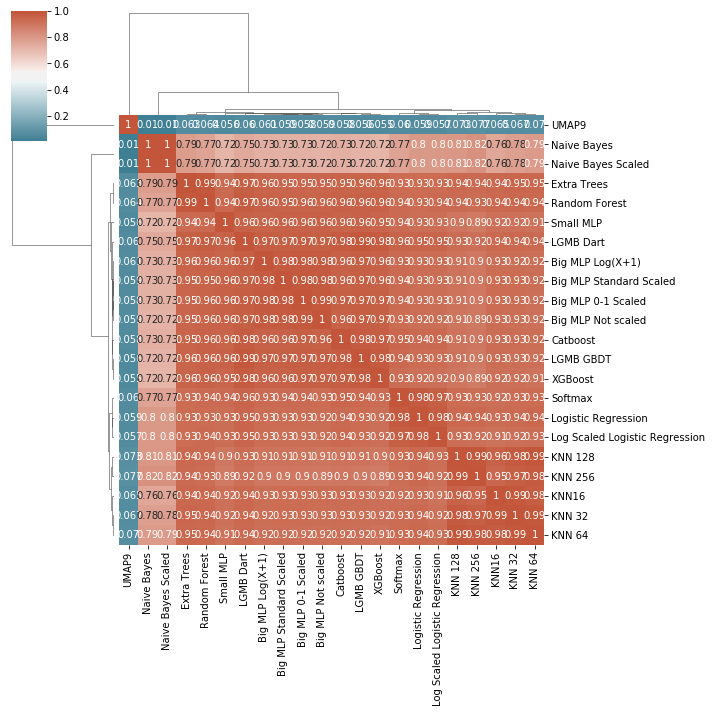

In [0]:
#corrlation map train

cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
ax = sns.clustermap(base_model_df_train.corr(), figsize= (10,10), cmap = cmap, annot=True).ax_row_dendrogram.set_visible(True)

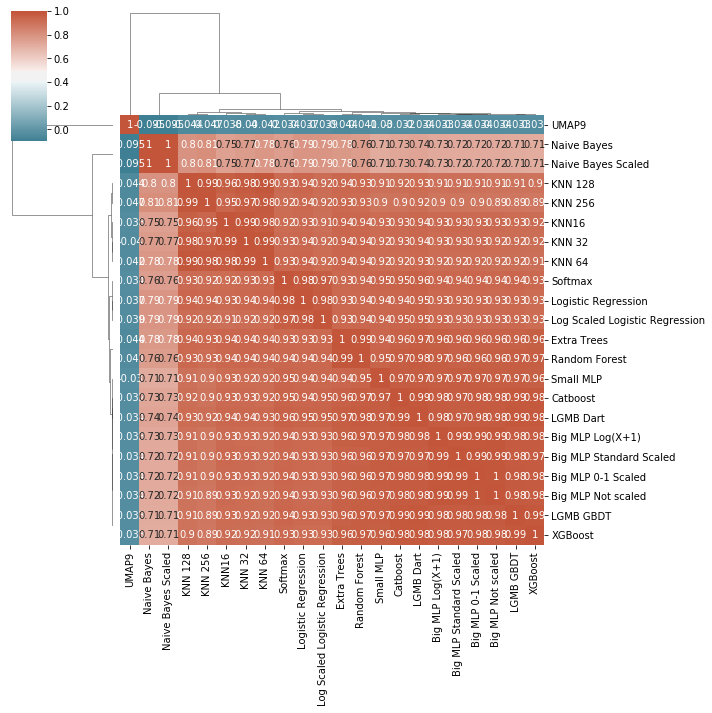

In [0]:
#corrlation map test

cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
ax = sns.clustermap(base_model_df_test.corr(), figsize= (10,10), cmap = cmap, annot=True).ax_row_dendrogram.set_visible(True)

## Train Model

#### Setup MLP Structure

In [0]:
# Best shape so far
n_base_models*9 -> 1000
ReLU
1000->1000
ReLU
1000->9

In [0]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        n_base_models = 21
        self.classifier = nn.Sequential(
            #nn.Dropout(0.3),
            nn.Linear(n_base_models*9, 1000),
            nn.ReLU(),

            #nn.Dropout(0.4),
            nn.Linear(1000,1000),
            nn.ReLU(),

            #nn.Dropout(0.2),
            nn.Linear(1000,9)
        )

    def forward(self,x):
        x = self.classifier(x)
        return x

#### Train NN Function

In [0]:
def train_NN(x, train_x, train_y, valid_x, valid_y, test_x):

    model = MLP().to('cuda')
    criterion = nn.CrossEntropyLoss().to('cuda')
    # 0.00000185
    # best so far 0.0001
    optimizer = optim.Adam(model.parameters(),weight_decay=0.00007)
    model.train()

    train_losses = []
    valid_losses = []
    epoch_nums = []
    epochs = 250
    best_valid_loss = 50
    log_interval = 10
    start_time = time.time()
    model.train()
    batch_size = 20000

    train_x = train_x.to('cuda')
    train_y = train_y.to('cuda')
    valid_x = valid_x.to('cuda')
    valid_y = valid_y.to('cuda')


    for epoch in range(epochs):

        permutation = torch.randperm(train_x.size()[0])

        for i in range(0,train_x.size()[0], batch_size):
          
            optimizer.zero_grad()

            indices = permutation[i:i+batch_size]
            batch_x, batch_y = train_x[indices], train_y[indices]

            outputs = model.forward(batch_x)
            loss = criterion(outputs, batch_y-1)

            loss.backward()
            optimizer.step()

        valid_l = criterion(model.forward(valid_x), valid_y-1).detach()
        train_l = criterion(model.forward(train_x), train_y-1).detach()

        train_losses.append(train_l)
        valid_losses.append(valid_l)
        epoch_nums.append(epoch)

        if valid_l < best_valid_loss:
          torch.save(model, 'best_model.pth')
          best_valid_loss = valid_l

        if epoch % log_interval == 0:
          print('Epoch: {} Train Loss: {:.3f} Validation Loss {:.3f} Best so far: {:.3f}'.format(epoch+1, train_l, valid_l, best_valid_loss))

    print('Time taken: ', time.time()-start_time)

    # Load best model
    best_model = torch.load('best_model.pth')
    best_model.eval()

    # Train set
    outputs = best_model.forward(x)
    probs = F.softmax(outputs, dim=1)
    y_train_pred = probs.cpu().detach().numpy()

    # Test set
    outputs = best_model.forward(test_x)
    probs = F.softmax(outputs, dim=1)
    y_test_pred = probs.cpu().detach().numpy()

    return y_train_pred, y_test_pred, train_losses, valid_losses, epoch_nums

#### K Folds Function

Running fold  1 of  20


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 Train Loss: 1.413 Validation Loss 1.415 Best so far: 1.415
Epoch: 11 Train Loss: 0.467 Validation Loss 0.471 Best so far: 0.471
Epoch: 21 Train Loss: 0.442 Validation Loss 0.445 Best so far: 0.445
Epoch: 31 Train Loss: 0.430 Validation Loss 0.436 Best so far: 0.436
Epoch: 41 Train Loss: 0.422 Validation Loss 0.431 Best so far: 0.431
Epoch: 51 Train Loss: 0.416 Validation Loss 0.426 Best so far: 0.426
Epoch: 61 Train Loss: 0.416 Validation Loss 0.426 Best so far: 0.424
Epoch: 71 Train Loss: 0.410 Validation Loss 0.424 Best so far: 0.421
Epoch: 81 Train Loss: 0.406 Validation Loss 0.421 Best so far: 0.420
Epoch: 91 Train Loss: 0.403 Validation Loss 0.420 Best so far: 0.418
Epoch: 101 Train Loss: 0.400 Validation Loss 0.418 Best so far: 0.418
Epoch: 111 Train Loss: 0.397 Validation Loss 0.419 Best so far: 0.418
Epoch: 121 Train Loss: 0.395 Validation Loss 0.418 Best so far: 0.417
Epoch: 131 Train Loss: 0.393 Validation Loss 0.418 Best so far: 0.417
Epoch: 141 Train Loss: 0.390 Va

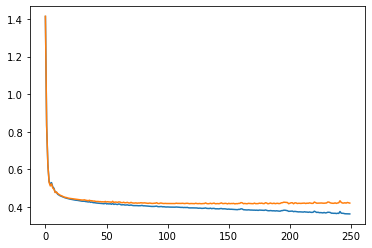

Running fold  2 of  20


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 Train Loss: 1.405 Validation Loss 1.413 Best so far: 1.413
Epoch: 11 Train Loss: 0.467 Validation Loss 0.508 Best so far: 0.508
Epoch: 21 Train Loss: 0.440 Validation Loss 0.481 Best so far: 0.481
Epoch: 31 Train Loss: 0.429 Validation Loss 0.471 Best so far: 0.471
Epoch: 41 Train Loss: 0.421 Validation Loss 0.463 Best so far: 0.463
Epoch: 51 Train Loss: 0.415 Validation Loss 0.460 Best so far: 0.458
Epoch: 61 Train Loss: 0.410 Validation Loss 0.454 Best so far: 0.454
Epoch: 71 Train Loss: 0.407 Validation Loss 0.454 Best so far: 0.453
Epoch: 81 Train Loss: 0.403 Validation Loss 0.451 Best so far: 0.451
Epoch: 91 Train Loss: 0.400 Validation Loss 0.450 Best so far: 0.450
Epoch: 101 Train Loss: 0.398 Validation Loss 0.451 Best so far: 0.449
Epoch: 111 Train Loss: 0.395 Validation Loss 0.448 Best so far: 0.448
Epoch: 121 Train Loss: 0.397 Validation Loss 0.451 Best so far: 0.448
Epoch: 131 Train Loss: 0.390 Validation Loss 0.449 Best so far: 0.447
Epoch: 141 Train Loss: 0.388 Va

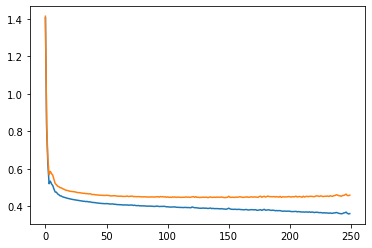

Running fold  3 of  20


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 Train Loss: 1.378 Validation Loss 1.382 Best so far: 1.382
Epoch: 11 Train Loss: 0.468 Validation Loss 0.475 Best so far: 0.475
Epoch: 21 Train Loss: 0.442 Validation Loss 0.447 Best so far: 0.447
Epoch: 31 Train Loss: 0.430 Validation Loss 0.435 Best so far: 0.435
Epoch: 41 Train Loss: 0.422 Validation Loss 0.429 Best so far: 0.427
Epoch: 51 Train Loss: 0.414 Validation Loss 0.422 Best so far: 0.422
Epoch: 61 Train Loss: 0.409 Validation Loss 0.420 Best so far: 0.419
Epoch: 71 Train Loss: 0.406 Validation Loss 0.419 Best so far: 0.418
Epoch: 81 Train Loss: 0.405 Validation Loss 0.420 Best so far: 0.417
Epoch: 91 Train Loss: 0.402 Validation Loss 0.418 Best so far: 0.417
Epoch: 101 Train Loss: 0.398 Validation Loss 0.417 Best so far: 0.417
Epoch: 111 Train Loss: 0.397 Validation Loss 0.419 Best so far: 0.416
Epoch: 121 Train Loss: 0.393 Validation Loss 0.418 Best so far: 0.416
Epoch: 131 Train Loss: 0.394 Validation Loss 0.420 Best so far: 0.416
Epoch: 141 Train Loss: 0.390 Va

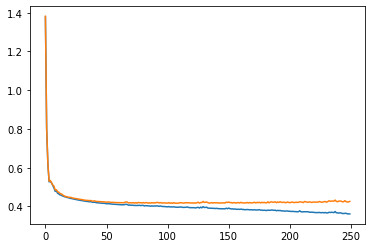

Running fold  4 of  20


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 Train Loss: 1.369 Validation Loss 1.371 Best so far: 1.371
Epoch: 11 Train Loss: 0.469 Validation Loss 0.450 Best so far: 0.450
Epoch: 21 Train Loss: 0.443 Validation Loss 0.427 Best so far: 0.427
Epoch: 31 Train Loss: 0.431 Validation Loss 0.417 Best so far: 0.417
Epoch: 41 Train Loss: 0.423 Validation Loss 0.411 Best so far: 0.411
Epoch: 51 Train Loss: 0.418 Validation Loss 0.408 Best so far: 0.407
Epoch: 61 Train Loss: 0.413 Validation Loss 0.405 Best so far: 0.405
Epoch: 71 Train Loss: 0.409 Validation Loss 0.404 Best so far: 0.403
Epoch: 81 Train Loss: 0.405 Validation Loss 0.402 Best so far: 0.402
Epoch: 91 Train Loss: 0.402 Validation Loss 0.401 Best so far: 0.401
Epoch: 101 Train Loss: 0.400 Validation Loss 0.401 Best so far: 0.401
Epoch: 111 Train Loss: 0.398 Validation Loss 0.401 Best so far: 0.400
Epoch: 121 Train Loss: 0.395 Validation Loss 0.401 Best so far: 0.400
Epoch: 131 Train Loss: 0.395 Validation Loss 0.404 Best so far: 0.399
Epoch: 141 Train Loss: 0.390 Va

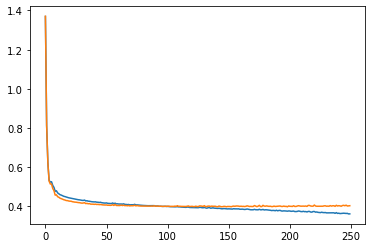

Running fold  5 of  20


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 Train Loss: 1.411 Validation Loss 1.413 Best so far: 1.413
Epoch: 11 Train Loss: 0.472 Validation Loss 0.458 Best so far: 0.458
Epoch: 21 Train Loss: 0.444 Validation Loss 0.435 Best so far: 0.435
Epoch: 31 Train Loss: 0.431 Validation Loss 0.424 Best so far: 0.424
Epoch: 41 Train Loss: 0.423 Validation Loss 0.420 Best so far: 0.419
Epoch: 51 Train Loss: 0.418 Validation Loss 0.418 Best so far: 0.416
Epoch: 61 Train Loss: 0.411 Validation Loss 0.413 Best so far: 0.413
Epoch: 71 Train Loss: 0.408 Validation Loss 0.412 Best so far: 0.412
Epoch: 81 Train Loss: 0.405 Validation Loss 0.411 Best so far: 0.411
Epoch: 91 Train Loss: 0.402 Validation Loss 0.410 Best so far: 0.409
Epoch: 101 Train Loss: 0.399 Validation Loss 0.410 Best so far: 0.409
Epoch: 111 Train Loss: 0.396 Validation Loss 0.409 Best so far: 0.409
Epoch: 121 Train Loss: 0.394 Validation Loss 0.410 Best so far: 0.409
Epoch: 131 Train Loss: 0.392 Validation Loss 0.409 Best so far: 0.408
Epoch: 141 Train Loss: 0.392 Va

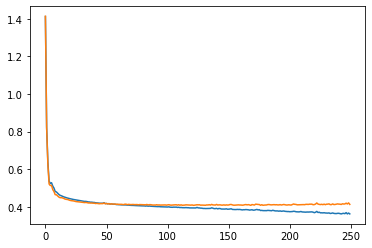

Running fold  6 of  20


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 Train Loss: 1.402 Validation Loss 1.403 Best so far: 1.403
Epoch: 11 Train Loss: 0.468 Validation Loss 0.470 Best so far: 0.470
Epoch: 21 Train Loss: 0.443 Validation Loss 0.449 Best so far: 0.449
Epoch: 31 Train Loss: 0.430 Validation Loss 0.437 Best so far: 0.437
Epoch: 41 Train Loss: 0.421 Validation Loss 0.431 Best so far: 0.430
Epoch: 51 Train Loss: 0.415 Validation Loss 0.427 Best so far: 0.426
Epoch: 61 Train Loss: 0.410 Validation Loss 0.424 Best so far: 0.424
Epoch: 71 Train Loss: 0.407 Validation Loss 0.424 Best so far: 0.423
Epoch: 81 Train Loss: 0.404 Validation Loss 0.424 Best so far: 0.422
Epoch: 91 Train Loss: 0.401 Validation Loss 0.423 Best so far: 0.422
Epoch: 101 Train Loss: 0.403 Validation Loss 0.427 Best so far: 0.422
Epoch: 111 Train Loss: 0.396 Validation Loss 0.422 Best so far: 0.421
Epoch: 121 Train Loss: 0.393 Validation Loss 0.423 Best so far: 0.421
Epoch: 131 Train Loss: 0.391 Validation Loss 0.423 Best so far: 0.421
Epoch: 141 Train Loss: 0.390 Va

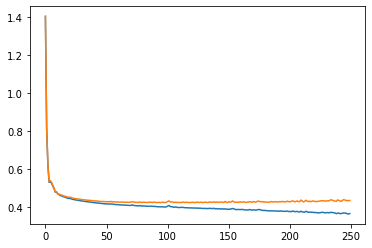

Running fold  7 of  20


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 Train Loss: 1.366 Validation Loss 1.369 Best so far: 1.369
Epoch: 11 Train Loss: 0.467 Validation Loss 0.491 Best so far: 0.491
Epoch: 21 Train Loss: 0.441 Validation Loss 0.468 Best so far: 0.468
Epoch: 31 Train Loss: 0.430 Validation Loss 0.458 Best so far: 0.457
Epoch: 41 Train Loss: 0.420 Validation Loss 0.449 Best so far: 0.449
Epoch: 51 Train Loss: 0.414 Validation Loss 0.444 Best so far: 0.444
Epoch: 61 Train Loss: 0.410 Validation Loss 0.441 Best so far: 0.441
Epoch: 71 Train Loss: 0.405 Validation Loss 0.438 Best so far: 0.438
Epoch: 81 Train Loss: 0.403 Validation Loss 0.438 Best so far: 0.437
Epoch: 91 Train Loss: 0.401 Validation Loss 0.437 Best so far: 0.436
Epoch: 101 Train Loss: 0.398 Validation Loss 0.436 Best so far: 0.435
Epoch: 111 Train Loss: 0.396 Validation Loss 0.436 Best so far: 0.435
Epoch: 121 Train Loss: 0.392 Validation Loss 0.433 Best so far: 0.433
Epoch: 131 Train Loss: 0.392 Validation Loss 0.435 Best so far: 0.433
Epoch: 141 Train Loss: 0.389 Va

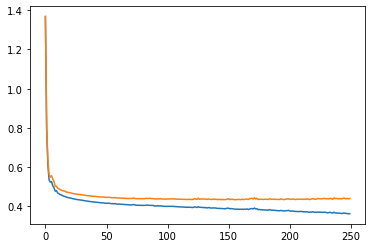

Running fold  8 of  20


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 Train Loss: 1.389 Validation Loss 1.395 Best so far: 1.395
Epoch: 11 Train Loss: 0.468 Validation Loss 0.486 Best so far: 0.486
Epoch: 21 Train Loss: 0.442 Validation Loss 0.462 Best so far: 0.462
Epoch: 31 Train Loss: 0.429 Validation Loss 0.454 Best so far: 0.454
Epoch: 41 Train Loss: 0.422 Validation Loss 0.451 Best so far: 0.451
Epoch: 51 Train Loss: 0.414 Validation Loss 0.447 Best so far: 0.447
Epoch: 61 Train Loss: 0.411 Validation Loss 0.447 Best so far: 0.445
Epoch: 71 Train Loss: 0.405 Validation Loss 0.443 Best so far: 0.443
Epoch: 81 Train Loss: 0.402 Validation Loss 0.443 Best so far: 0.443
Epoch: 91 Train Loss: 0.399 Validation Loss 0.442 Best so far: 0.442
Epoch: 101 Train Loss: 0.397 Validation Loss 0.443 Best so far: 0.442
Epoch: 111 Train Loss: 0.394 Validation Loss 0.442 Best so far: 0.442
Epoch: 121 Train Loss: 0.392 Validation Loss 0.443 Best so far: 0.442
Epoch: 131 Train Loss: 0.391 Validation Loss 0.445 Best so far: 0.442
Epoch: 141 Train Loss: 0.387 Va

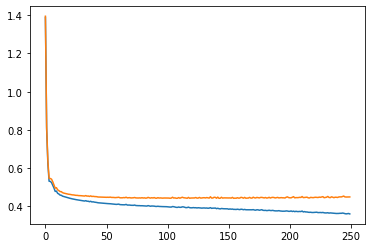

Running fold  9 of  20


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 Train Loss: 1.406 Validation Loss 1.403 Best so far: 1.403
Epoch: 11 Train Loss: 0.471 Validation Loss 0.476 Best so far: 0.476
Epoch: 21 Train Loss: 0.443 Validation Loss 0.445 Best so far: 0.445
Epoch: 31 Train Loss: 0.431 Validation Loss 0.435 Best so far: 0.435
Epoch: 41 Train Loss: 0.422 Validation Loss 0.427 Best so far: 0.427
Epoch: 51 Train Loss: 0.417 Validation Loss 0.426 Best so far: 0.423
Epoch: 61 Train Loss: 0.413 Validation Loss 0.422 Best so far: 0.422
Epoch: 71 Train Loss: 0.407 Validation Loss 0.422 Best so far: 0.421
Epoch: 81 Train Loss: 0.404 Validation Loss 0.422 Best so far: 0.419
Epoch: 91 Train Loss: 0.402 Validation Loss 0.421 Best so far: 0.418
Epoch: 101 Train Loss: 0.399 Validation Loss 0.423 Best so far: 0.418
Epoch: 111 Train Loss: 0.399 Validation Loss 0.421 Best so far: 0.417
Epoch: 121 Train Loss: 0.396 Validation Loss 0.422 Best so far: 0.416
Epoch: 131 Train Loss: 0.390 Validation Loss 0.418 Best so far: 0.416
Epoch: 141 Train Loss: 0.390 Va

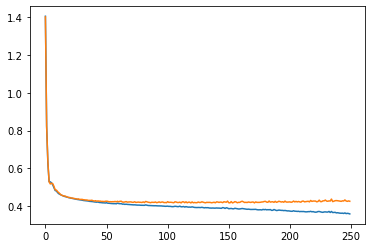

Running fold  10 of  20


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 Train Loss: 1.404 Validation Loss 1.405 Best so far: 1.405
Epoch: 11 Train Loss: 0.468 Validation Loss 0.467 Best so far: 0.467
Epoch: 21 Train Loss: 0.443 Validation Loss 0.443 Best so far: 0.443
Epoch: 31 Train Loss: 0.430 Validation Loss 0.432 Best so far: 0.432
Epoch: 41 Train Loss: 0.421 Validation Loss 0.426 Best so far: 0.426
Epoch: 51 Train Loss: 0.419 Validation Loss 0.427 Best so far: 0.423
Epoch: 61 Train Loss: 0.410 Validation Loss 0.422 Best so far: 0.421
Epoch: 71 Train Loss: 0.408 Validation Loss 0.421 Best so far: 0.421
Epoch: 81 Train Loss: 0.404 Validation Loss 0.419 Best so far: 0.419
Epoch: 91 Train Loss: 0.403 Validation Loss 0.420 Best so far: 0.419
Epoch: 101 Train Loss: 0.399 Validation Loss 0.420 Best so far: 0.418
Epoch: 111 Train Loss: 0.396 Validation Loss 0.418 Best so far: 0.417
Epoch: 121 Train Loss: 0.395 Validation Loss 0.418 Best so far: 0.417
Epoch: 131 Train Loss: 0.392 Validation Loss 0.417 Best so far: 0.417
Epoch: 141 Train Loss: 0.390 Va

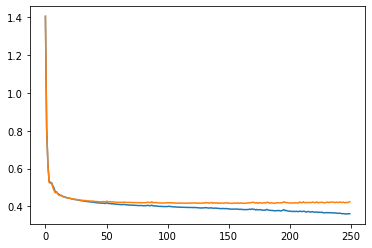

Running fold  11 of  20


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 Train Loss: 1.404 Validation Loss 1.405 Best so far: 1.405
Epoch: 11 Train Loss: 0.467 Validation Loss 0.481 Best so far: 0.481
Epoch: 21 Train Loss: 0.442 Validation Loss 0.455 Best so far: 0.455
Epoch: 31 Train Loss: 0.431 Validation Loss 0.445 Best so far: 0.445
Epoch: 41 Train Loss: 0.422 Validation Loss 0.436 Best so far: 0.436
Epoch: 51 Train Loss: 0.415 Validation Loss 0.431 Best so far: 0.431
Epoch: 61 Train Loss: 0.412 Validation Loss 0.429 Best so far: 0.429
Epoch: 71 Train Loss: 0.407 Validation Loss 0.426 Best so far: 0.426
Epoch: 81 Train Loss: 0.404 Validation Loss 0.425 Best so far: 0.425
Epoch: 91 Train Loss: 0.401 Validation Loss 0.425 Best so far: 0.424
Epoch: 101 Train Loss: 0.398 Validation Loss 0.423 Best so far: 0.423
Epoch: 111 Train Loss: 0.396 Validation Loss 0.423 Best so far: 0.423
Epoch: 121 Train Loss: 0.395 Validation Loss 0.425 Best so far: 0.422
Epoch: 131 Train Loss: 0.391 Validation Loss 0.422 Best so far: 0.422
Epoch: 141 Train Loss: 0.389 Va

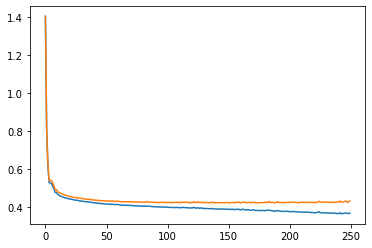

Running fold  12 of  20


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 Train Loss: 1.359 Validation Loss 1.362 Best so far: 1.362
Epoch: 11 Train Loss: 0.471 Validation Loss 0.475 Best so far: 0.475
Epoch: 21 Train Loss: 0.443 Validation Loss 0.448 Best so far: 0.448
Epoch: 31 Train Loss: 0.432 Validation Loss 0.440 Best so far: 0.440
Epoch: 41 Train Loss: 0.422 Validation Loss 0.432 Best so far: 0.432
Epoch: 51 Train Loss: 0.416 Validation Loss 0.428 Best so far: 0.428
Epoch: 61 Train Loss: 0.411 Validation Loss 0.427 Best so far: 0.426
Epoch: 71 Train Loss: 0.407 Validation Loss 0.425 Best so far: 0.424
Epoch: 81 Train Loss: 0.405 Validation Loss 0.424 Best so far: 0.423
Epoch: 91 Train Loss: 0.401 Validation Loss 0.423 Best so far: 0.423
Epoch: 101 Train Loss: 0.399 Validation Loss 0.422 Best so far: 0.421
Epoch: 111 Train Loss: 0.396 Validation Loss 0.423 Best so far: 0.421
Epoch: 121 Train Loss: 0.393 Validation Loss 0.422 Best so far: 0.421
Epoch: 131 Train Loss: 0.391 Validation Loss 0.421 Best so far: 0.421
Epoch: 141 Train Loss: 0.393 Va

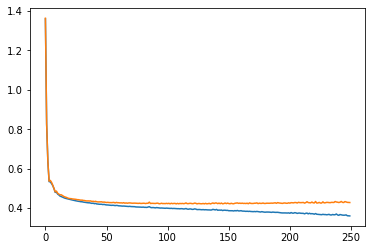

Running fold  13 of  20


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 Train Loss: 1.403 Validation Loss 1.400 Best so far: 1.400
Epoch: 11 Train Loss: 0.467 Validation Loss 0.462 Best so far: 0.462
Epoch: 21 Train Loss: 0.442 Validation Loss 0.439 Best so far: 0.439
Epoch: 31 Train Loss: 0.430 Validation Loss 0.429 Best so far: 0.429
Epoch: 41 Train Loss: 0.422 Validation Loss 0.422 Best so far: 0.422
Epoch: 51 Train Loss: 0.415 Validation Loss 0.416 Best so far: 0.416
Epoch: 61 Train Loss: 0.411 Validation Loss 0.413 Best so far: 0.413
Epoch: 71 Train Loss: 0.407 Validation Loss 0.412 Best so far: 0.412
Epoch: 81 Train Loss: 0.404 Validation Loss 0.411 Best so far: 0.411
Epoch: 91 Train Loss: 0.401 Validation Loss 0.410 Best so far: 0.410
Epoch: 101 Train Loss: 0.398 Validation Loss 0.409 Best so far: 0.409
Epoch: 111 Train Loss: 0.397 Validation Loss 0.411 Best so far: 0.409
Epoch: 121 Train Loss: 0.394 Validation Loss 0.410 Best so far: 0.409
Epoch: 131 Train Loss: 0.394 Validation Loss 0.412 Best so far: 0.409
Epoch: 141 Train Loss: 0.389 Va

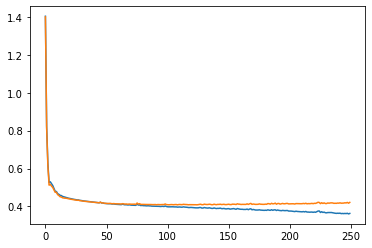

Running fold  14 of  20


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 Train Loss: 1.381 Validation Loss 1.380 Best so far: 1.380
Epoch: 11 Train Loss: 0.468 Validation Loss 0.467 Best so far: 0.467
Epoch: 21 Train Loss: 0.442 Validation Loss 0.438 Best so far: 0.438
Epoch: 31 Train Loss: 0.431 Validation Loss 0.427 Best so far: 0.427
Epoch: 41 Train Loss: 0.422 Validation Loss 0.419 Best so far: 0.419
Epoch: 51 Train Loss: 0.416 Validation Loss 0.416 Best so far: 0.416
Epoch: 61 Train Loss: 0.412 Validation Loss 0.413 Best so far: 0.413
Epoch: 71 Train Loss: 0.408 Validation Loss 0.413 Best so far: 0.410
Epoch: 81 Train Loss: 0.404 Validation Loss 0.410 Best so far: 0.409
Epoch: 91 Train Loss: 0.403 Validation Loss 0.410 Best so far: 0.409
Epoch: 101 Train Loss: 0.400 Validation Loss 0.408 Best so far: 0.408
Epoch: 111 Train Loss: 0.397 Validation Loss 0.406 Best so far: 0.406
Epoch: 121 Train Loss: 0.395 Validation Loss 0.408 Best so far: 0.406
Epoch: 131 Train Loss: 0.391 Validation Loss 0.408 Best so far: 0.406
Epoch: 141 Train Loss: 0.390 Va

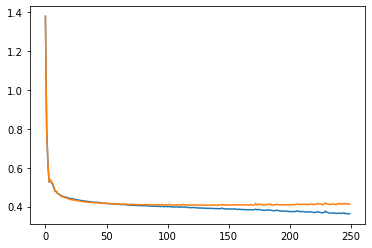

Running fold  15 of  20


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 Train Loss: 1.401 Validation Loss 1.398 Best so far: 1.398
Epoch: 11 Train Loss: 0.470 Validation Loss 0.470 Best so far: 0.470
Epoch: 21 Train Loss: 0.443 Validation Loss 0.442 Best so far: 0.442
Epoch: 31 Train Loss: 0.431 Validation Loss 0.433 Best so far: 0.433
Epoch: 41 Train Loss: 0.422 Validation Loss 0.427 Best so far: 0.427
Epoch: 51 Train Loss: 0.417 Validation Loss 0.424 Best so far: 0.424
Epoch: 61 Train Loss: 0.411 Validation Loss 0.420 Best so far: 0.420
Epoch: 71 Train Loss: 0.409 Validation Loss 0.419 Best so far: 0.419
Epoch: 81 Train Loss: 0.404 Validation Loss 0.419 Best so far: 0.418
Epoch: 91 Train Loss: 0.402 Validation Loss 0.418 Best so far: 0.417
Epoch: 101 Train Loss: 0.399 Validation Loss 0.419 Best so far: 0.416
Epoch: 111 Train Loss: 0.397 Validation Loss 0.417 Best so far: 0.416
Epoch: 121 Train Loss: 0.394 Validation Loss 0.417 Best so far: 0.416
Epoch: 131 Train Loss: 0.391 Validation Loss 0.417 Best so far: 0.416
Epoch: 141 Train Loss: 0.390 Va

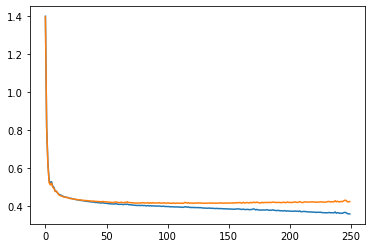

Running fold  16 of  20


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 Train Loss: 1.439 Validation Loss 1.428 Best so far: 1.428
Epoch: 11 Train Loss: 0.470 Validation Loss 0.428 Best so far: 0.428
Epoch: 21 Train Loss: 0.444 Validation Loss 0.407 Best so far: 0.407
Epoch: 31 Train Loss: 0.432 Validation Loss 0.398 Best so far: 0.398
Epoch: 41 Train Loss: 0.423 Validation Loss 0.392 Best so far: 0.392
Epoch: 51 Train Loss: 0.419 Validation Loss 0.390 Best so far: 0.389
Epoch: 61 Train Loss: 0.412 Validation Loss 0.387 Best so far: 0.386
Epoch: 71 Train Loss: 0.408 Validation Loss 0.384 Best so far: 0.384
Epoch: 81 Train Loss: 0.406 Validation Loss 0.385 Best so far: 0.383
Epoch: 91 Train Loss: 0.405 Validation Loss 0.387 Best so far: 0.383
Epoch: 101 Train Loss: 0.401 Validation Loss 0.383 Best so far: 0.383
Epoch: 111 Train Loss: 0.397 Validation Loss 0.383 Best so far: 0.381
Epoch: 121 Train Loss: 0.395 Validation Loss 0.382 Best so far: 0.381
Epoch: 131 Train Loss: 0.394 Validation Loss 0.384 Best so far: 0.381
Epoch: 141 Train Loss: 0.391 Va

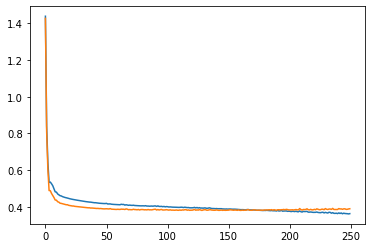

Running fold  17 of  20


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 Train Loss: 1.403 Validation Loss 1.400 Best so far: 1.400
Epoch: 11 Train Loss: 0.467 Validation Loss 0.474 Best so far: 0.474
Epoch: 21 Train Loss: 0.442 Validation Loss 0.445 Best so far: 0.445
Epoch: 31 Train Loss: 0.432 Validation Loss 0.438 Best so far: 0.435
Epoch: 41 Train Loss: 0.421 Validation Loss 0.427 Best so far: 0.427
Epoch: 51 Train Loss: 0.415 Validation Loss 0.422 Best so far: 0.422
Epoch: 61 Train Loss: 0.411 Validation Loss 0.420 Best so far: 0.419
Epoch: 71 Train Loss: 0.407 Validation Loss 0.417 Best so far: 0.417
Epoch: 81 Train Loss: 0.406 Validation Loss 0.416 Best so far: 0.414
Epoch: 91 Train Loss: 0.401 Validation Loss 0.416 Best so far: 0.413
Epoch: 101 Train Loss: 0.403 Validation Loss 0.421 Best so far: 0.413
Epoch: 111 Train Loss: 0.397 Validation Loss 0.413 Best so far: 0.411
Epoch: 121 Train Loss: 0.393 Validation Loss 0.411 Best so far: 0.411
Epoch: 131 Train Loss: 0.391 Validation Loss 0.411 Best so far: 0.411
Epoch: 141 Train Loss: 0.394 Va

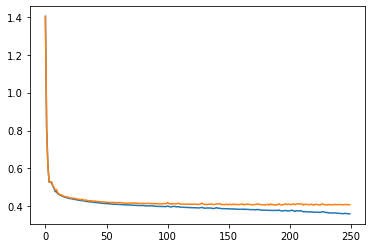

Running fold  18 of  20


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 Train Loss: 1.400 Validation Loss 1.399 Best so far: 1.399
Epoch: 11 Train Loss: 0.469 Validation Loss 0.472 Best so far: 0.472
Epoch: 21 Train Loss: 0.442 Validation Loss 0.452 Best so far: 0.452
Epoch: 31 Train Loss: 0.429 Validation Loss 0.442 Best so far: 0.442
Epoch: 41 Train Loss: 0.420 Validation Loss 0.436 Best so far: 0.436
Epoch: 51 Train Loss: 0.414 Validation Loss 0.435 Best so far: 0.434
Epoch: 61 Train Loss: 0.411 Validation Loss 0.432 Best so far: 0.432
Epoch: 71 Train Loss: 0.406 Validation Loss 0.431 Best so far: 0.431
Epoch: 81 Train Loss: 0.402 Validation Loss 0.430 Best so far: 0.429
Epoch: 91 Train Loss: 0.400 Validation Loss 0.431 Best so far: 0.429
Epoch: 101 Train Loss: 0.400 Validation Loss 0.429 Best so far: 0.427
Epoch: 111 Train Loss: 0.395 Validation Loss 0.429 Best so far: 0.427
Epoch: 121 Train Loss: 0.393 Validation Loss 0.430 Best so far: 0.427
Epoch: 131 Train Loss: 0.391 Validation Loss 0.431 Best so far: 0.427
Epoch: 141 Train Loss: 0.389 Va

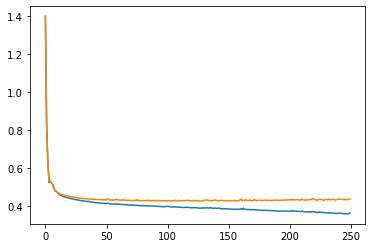

Running fold  19 of  20


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 Train Loss: 1.390 Validation Loss 1.392 Best so far: 1.392
Epoch: 11 Train Loss: 0.470 Validation Loss 0.476 Best so far: 0.476
Epoch: 21 Train Loss: 0.442 Validation Loss 0.453 Best so far: 0.453
Epoch: 31 Train Loss: 0.430 Validation Loss 0.444 Best so far: 0.444
Epoch: 41 Train Loss: 0.421 Validation Loss 0.438 Best so far: 0.438
Epoch: 51 Train Loss: 0.415 Validation Loss 0.436 Best so far: 0.436
Epoch: 61 Train Loss: 0.411 Validation Loss 0.434 Best so far: 0.433
Epoch: 71 Train Loss: 0.407 Validation Loss 0.433 Best so far: 0.432
Epoch: 81 Train Loss: 0.406 Validation Loss 0.434 Best so far: 0.431
Epoch: 91 Train Loss: 0.400 Validation Loss 0.432 Best so far: 0.431
Epoch: 101 Train Loss: 0.399 Validation Loss 0.432 Best so far: 0.430
Epoch: 111 Train Loss: 0.396 Validation Loss 0.433 Best so far: 0.430
Epoch: 121 Train Loss: 0.393 Validation Loss 0.432 Best so far: 0.430
Epoch: 131 Train Loss: 0.391 Validation Loss 0.432 Best so far: 0.430
Epoch: 141 Train Loss: 0.389 Va

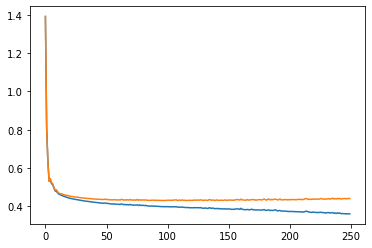

Running fold  20 of  20


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 Train Loss: 1.383 Validation Loss 1.382 Best so far: 1.382
Epoch: 11 Train Loss: 0.469 Validation Loss 0.462 Best so far: 0.462
Epoch: 21 Train Loss: 0.443 Validation Loss 0.437 Best so far: 0.437
Epoch: 31 Train Loss: 0.431 Validation Loss 0.425 Best so far: 0.425
Epoch: 41 Train Loss: 0.422 Validation Loss 0.417 Best so far: 0.417
Epoch: 51 Train Loss: 0.416 Validation Loss 0.413 Best so far: 0.413
Epoch: 61 Train Loss: 0.411 Validation Loss 0.409 Best so far: 0.409
Epoch: 71 Train Loss: 0.408 Validation Loss 0.408 Best so far: 0.407
Epoch: 81 Train Loss: 0.405 Validation Loss 0.407 Best so far: 0.407
Epoch: 91 Train Loss: 0.403 Validation Loss 0.407 Best so far: 0.406
Epoch: 101 Train Loss: 0.399 Validation Loss 0.405 Best so far: 0.405
Epoch: 111 Train Loss: 0.397 Validation Loss 0.406 Best so far: 0.404
Epoch: 121 Train Loss: 0.395 Validation Loss 0.406 Best so far: 0.404
Epoch: 131 Train Loss: 0.391 Validation Loss 0.403 Best so far: 0.403
Epoch: 141 Train Loss: 0.389 Va

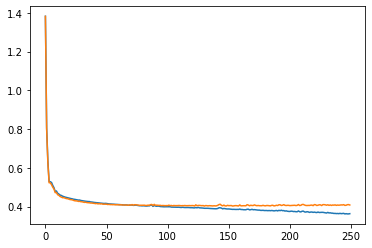

In [0]:
# Deep MLP with K Fold Stacking
train_preds = np.zeros((s_train.shape[0],9))
test_preds_array = []
train_preds_array = []
k=1
test_x = torch.tensor(s_test)
test_x = Variable(test_x).float().to('cuda')

whole_train_x = torch.tensor(s_train)
whole_train_x = Variable(whole_train_x).float().to('cuda')

for train_index, valid_index in kf.split(s_train, labels):


    print('Running fold ', k, 'of ', kf.n_splits)
    k += 1

    train_x, valid_x = s_train[train_index], s_train[valid_index]
    train_y, valid_y = labels.iloc[train_index], labels.iloc[valid_index]

    train_x = torch.tensor(train_x)
    train_y = torch.tensor(train_y.values)
    valid_x = torch.tensor(valid_x)
    valid_y = torch.tensor(valid_y.values)
    
    train_x = Variable(train_x).float()
    train_y = Variable(train_y).type(torch.LongTensor)
    valid_x = Variable(valid_x).float()
    valid_y = Variable(valid_y).type(torch.LongTensor)
    
    train_preds, test_preds, train_losses, valid_losses, epoch_nums = train_NN(whole_train_x, train_x, train_y, valid_x, valid_y, test_x)

    # For this level, both train and test are the average preds across the whole dataset
    train_preds_array.append(train_preds)
    test_preds_array.append(test_preds)

    plt.figure()
    plt.plot(epoch_nums, train_losses)
    plt.plot(epoch_nums, valid_losses)
    plt.show()

train_preds = np.mean(train_preds_array, axis=0)
test_preds = np.mean(test_preds_array, axis=0)


In [0]:
# Save the results?
# Training

if True:
    # Training
    fname = models_dir + '/train-metaMLP'
    _ = joblib.dump(train_preds, fname, compress=9)

    # Test
    fname = models_dir + '/test-metaMLP'
    _ = joblib.dump(test_preds, fname, compress=9)

## Submit Results

In [0]:
os.environ['KAGGLE_USERNAME'] = "benmcarthur" # username from the json file
os.environ['KAGGLE_KEY'] = "a89502eb26498960de769db301645abe" # key from the json file

In [0]:
submit = np.c_[ pd.to_numeric(ids, downcast='integer'), test_preds ]
header = 'id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9'
fmt='%i, %1.8f, %1.8f, %1.8f, %1.8f, %1.8f, %1.8f, %1.8f, %1.8f, %1.8f'
np.savetxt('submission.csv', submit, delimiter=',', header=header, comments='',fmt=fmt)
!kaggle competitions submit -c otto-group-product-classification-challenge -f submission.csv -m "MLP Meta Learner k=20 lr=0.00007 +logreg +scaledlogreg"

100% 15.7M/15.7M [00:02<00:00, 7.27MB/s]
Successfully submitted to Otto Group Product Classification Challenge